In [429]:
import numpy as np  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import random  # type: ignore

In [430]:
NUM_ITERATIONS = 10
NUM_PARTICLES = 10
EARLY_STOPPING_PATIENCE = 30

In [431]:
w = 0.5
c1 = 1
c2 = 2

In [432]:
def cost_function(position):
    y1 = -((position - 10) ** 2) + 4
    y2 = -((position + 10) ** 2) + 4
    return y1, y2

In [433]:
def generate_particle():
    position = np.random.uniform(low=-100.0, high=100.0, size=1)
    position = position.item()

    return {
        "position": position,
        "score": cost_function(position),
        "velocity": random.random(),
        "pbest": [position],
    }

In [434]:
def calculate_velocity(w, x, v, c1, c2, pbest, gbest):
    r1 = random.random()
    r2 = random.random()
    
    return w * v + c1 * r1 * (pbest - x) + c2 * r2 * (gbest - x)

In [435]:
def get_non_dominated_particles(positions):
    is_position_dominated = [False] * len(positions)

    for i in range(len(positions)):
        for j in range(len(positions)):
            if i != j:
                y1_i, y2_i = cost_function(positions[i])
                y1_j, y2_j = cost_function(positions[j])

                if (
                    (y1_j >= y1_i)
                    and (y2_j >= y2_i)
                    and ((y1_j > y1_i) or (y2_j > y2_i))
                ):
                    is_position_dominated[i] = True
                    break

    return [
        positions[i] for i in range(len(positions)) if is_position_dominated[i] is False
    ]

In [436]:
def update_position(particles, w, c1, c2, gbest):
    if gbest is None:
        gbest = particles[0]["pbest"]

    for particle in particles:
        particle["velocity"] = calculate_velocity(
            w,
            particle["position"],
            particle["velocity"],
            c1,
            c2,
            random.choice(particle["pbest"]),
            random.choice(gbest),
        )

        particle["position"] = particle["position"] + particle["velocity"]
        particle["score"] = cost_function(particle["position"])

        pbest_copy = particle["pbest"].copy()
        pbest_copy.append(particle["position"])

        particle["pbest"] = get_non_dominated_particles(pbest_copy)

        gbest_copy = gbest.copy()
        gbest_copy.append(particle["position"])

        gbest = get_non_dominated_particles(gbest_copy)

    return gbest

In [437]:
def plot(particles):
    # Obtendo os valores de posição como NumPy array
    positions = [particle["position"] for particle in particles]

    # Criando o gráfico com uma linha horizontal e pontos em positions
    plt.figure(figsize=(22, 4))
    plt.plot(
        positions, [0] * len(positions), marker="o", linestyle="", label="Pontos"
    )  # Plotando pontos em positions, eixo y fixado em zero
    plt.xlabel("Valor de X")  # Nomeando o eixo x
    plt.ylabel("Valor de Y")  # Nomeando o eixo y
    plt.title("Gráfico de Linha Unidimensional com Pontos")
    plt.xlim(-100, 100)
    plt.legend()  # Mostrando a legenda
    plt.grid(True)  # Adicionando grade ao gráfico (opcional)
    plt.show()  # Exibindo o gráfico

In [438]:
particles = [generate_particle() for _ in range(NUM_PARTICLES)]

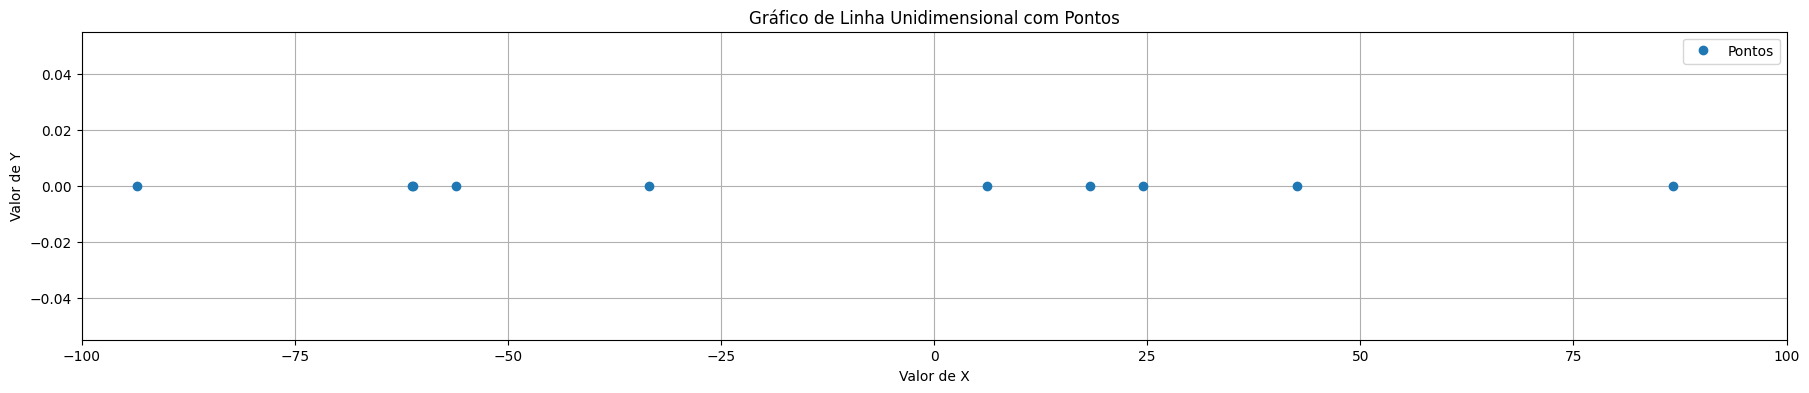

In [439]:
plot(particles)

In [440]:
i = 0
gbest = None
early_stopping_count = 0
last_gbest = None

while True:
    print(f"Iteration {i+1}")

    gbest = update_position(particles, w, c1, c2, gbest)

    if last_gbest != gbest:
        early_stopping_count = 0
        last_gbest = gbest
    else:
        early_stopping_count += 1

    i += 1

    if early_stopping_count == EARLY_STOPPING_PATIENCE:
        print("Early Stopping!")
        break

    if i == NUM_ITERATIONS:
        break

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


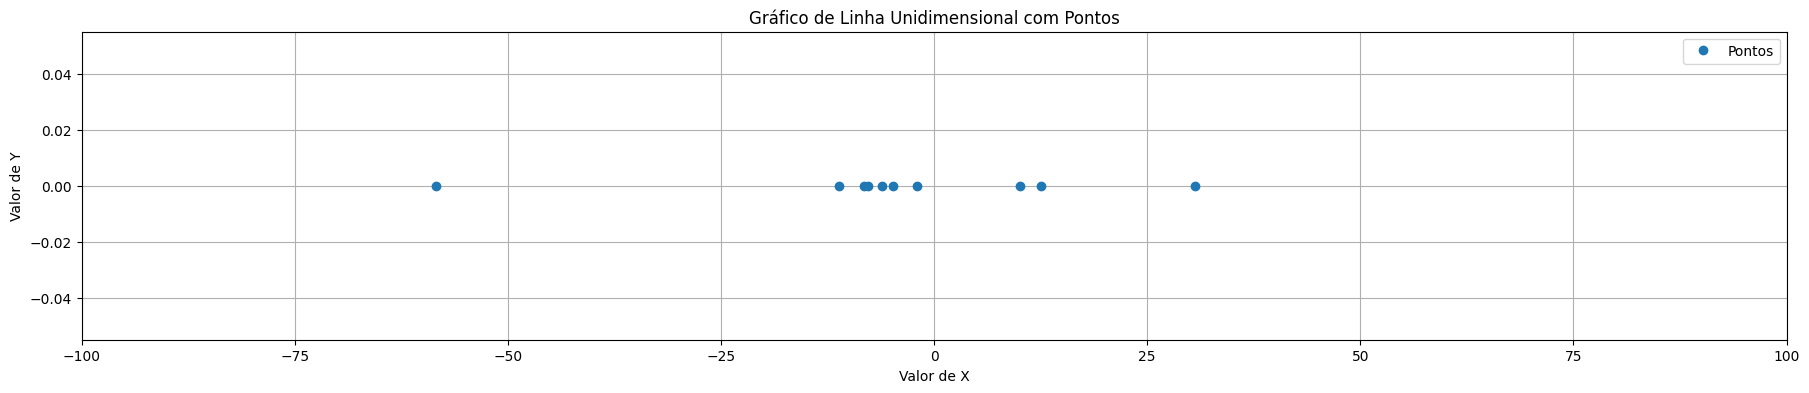

In [441]:
plot(particles)

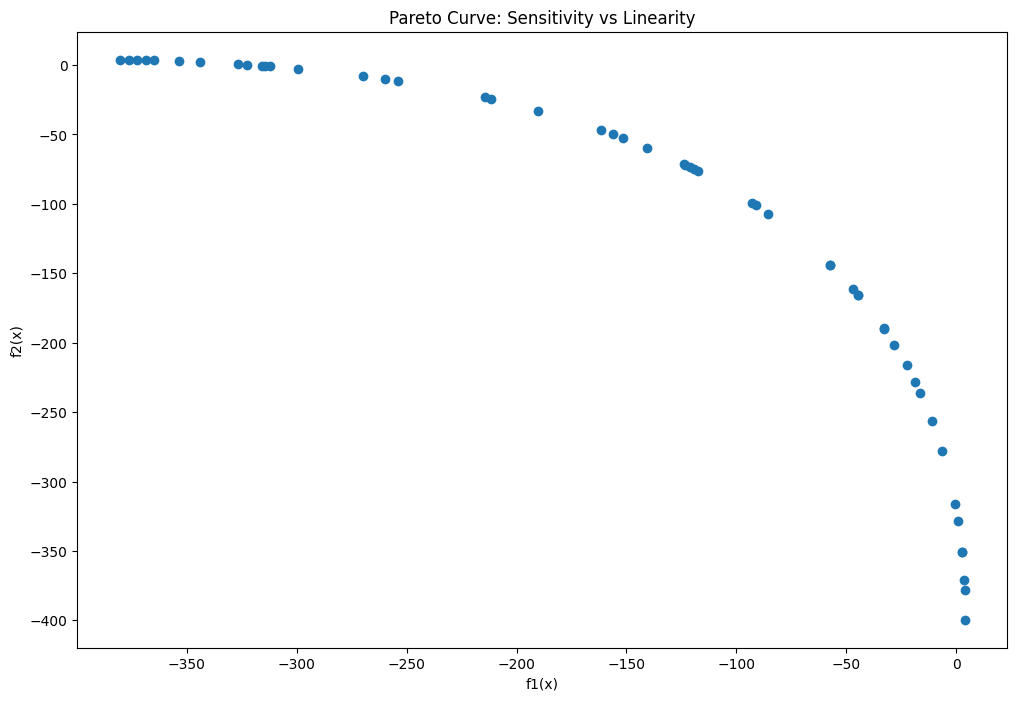

In [442]:
y1 = [cost_function(best)[0] for best in gbest]
y2 = [cost_function(best)[1] for best in gbest]

# Plotting the Pareto chart
plt.figure(figsize=(12, 8))
# Pontos não dominados
plt.scatter(y1, y2, marker="o", label="Non-dominated particles")
plt.xlabel("f1(x)")
plt.ylabel("f2(x)")
plt.title("Pareto Curve: Sensitivity vs Linearity")
plt.show()

In [443]:
def perpendicular_distance(point, line_start, line_end):
    line_vector = np.array(line_end) - np.array(line_start)
    point_vector = np.array(point) - np.array(line_start)
    line_length = np.linalg.norm(line_vector)
    if line_length == 0:
        return np.linalg.norm(point_vector)
    else:
        line_vector /= line_length
        projection = np.dot(point_vector, line_vector)
        perpendicular_vector = point_vector - projection * line_vector
        return np.linalg.norm(perpendicular_vector)

In [444]:
def find_knee_point(sorted_particles):
    knee_point = None
    max_distance = -np.inf
    for i in range(1, len(sorted_particles) - 1):
        dist = perpendicular_distance(
            cost_function(sorted_particles[i]),
            cost_function(sorted_particles[0]),
            cost_function(sorted_particles[-1]),
        )
        if dist > max_distance:
            max_distance = dist
            knee_point = sorted_particles[i]
    return knee_point

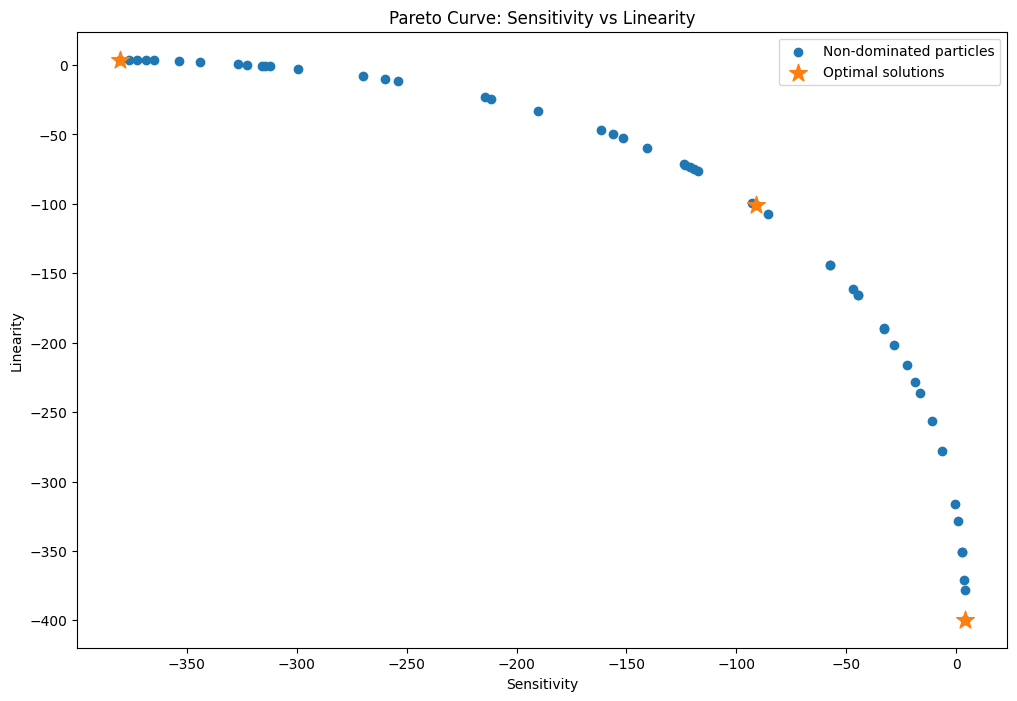

In [445]:
sorted_particles = sorted(gbest, key=lambda best: cost_function(best)[0])

knee_point = find_knee_point(sorted_particles)

solutions = [sorted_particles[0], knee_point, sorted_particles[-1]]

paretto_sensitivity = [cost_function(particle)[0] for particle in solutions]
paretto_linearity = [cost_function(particle)[1] for particle in solutions]

# Plotando o gráfico de Pareto
plt.figure(figsize=(12, 8))

# Pontos não dominados
plt.scatter(y1, y2, marker="o",  label="Non-dominated particles")

# Pontos ótimos
plt.scatter(paretto_sensitivity, paretto_linearity, s=175, marker="*",  label="Optimal solutions")

plt.xlabel("Sensitivity")
plt.ylabel("Linearity")
plt.title("Pareto Curve: Sensitivity vs Linearity")
plt.legend()
plt.show()